#Imports

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import joblib

#Load Dataset

In [3]:
df = pd.read_csv('heart_disease_uci.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [4]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("Columns:", df.columns.tolist())

# Common target names: 'num' or 'target'
if 'num' in df.columns:
    target_col = 'num'
elif 'target' in df.columns:
    target_col = 'target'
else:
    # try to guess
    print("No obvious 'num' or 'target' column. Printing columns to inspect.")
    target_col = None
    print(df.columns.tolist())

# Standardize target to 0 (no disease) / 1 (disease present)
if target_col is not None:
    # some variants encode 0=no disease, 1-4 disease severity. Make binary
    df['target'] = df[target_col].apply(lambda x: 1 if x != 0 else 0).astype(int)
    print("Target distribution (0 = no disease, 1 = disease):")
    print(df['target'].value_counts())
else:
    raise ValueError("Please ensure dataset has a 'num' or 'target' column indicating disease presence.")


Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
Target distribution (0 = no disease, 1 = disease):
target
1    509
0    411
Name: count, dtype: int64


#EDA

In [5]:
print("Missing values per column:\n", df.isnull().sum())
print("\nTotal duplicates:", df.duplicated().sum())

print("\nSummary statistics:")
display(df.describe(include='all').T)

Missing values per column:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
target        0
dtype: int64

Total duplicates: 0

Summary statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,920.0,NaN,NaN,NaN,460.5,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,NaN,NaN,NaN,53.51087,9.424685,28.0,47.0,54.0,60.0,77.0
sex,920,2,Male,726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dataset,920,4,Cleveland,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cp,920,4,asymptomatic,496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,861.0,NaN,NaN,NaN,132.132404,19.06607,0.0,120.0,130.0,140.0,200.0
chol,890.0,NaN,NaN,NaN,199.130337,110.78081,0.0,175.0,223.0,268.0,603.0
fbs,830,2,False,692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restecg,918,3,normal,551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thalch,865.0,NaN,NaN,NaN,137.545665,25.926276,60.0,120.0,140.0,157.0,202.0


#Data Visualization

<Figure size 1400x1000 with 0 Axes>

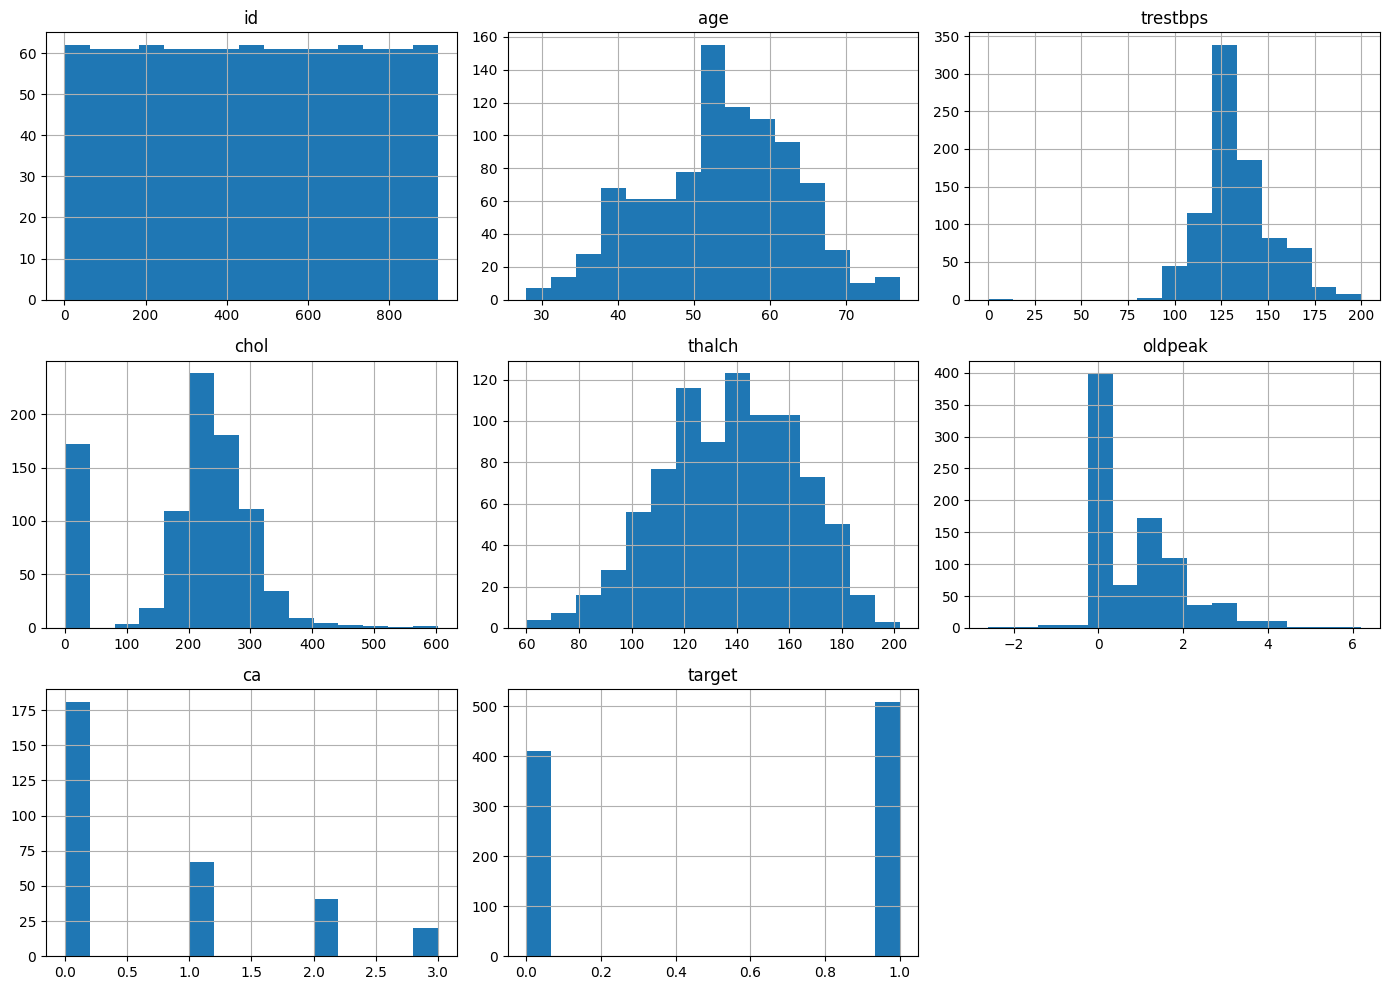

In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != target_col]

plt.figure(figsize=(14, 10))
df[num_cols].hist(bins=15, layout=(int(np.ceil(len(num_cols)/3)), 3), figsize=(14,10))
plt.tight_layout()
plt.show()

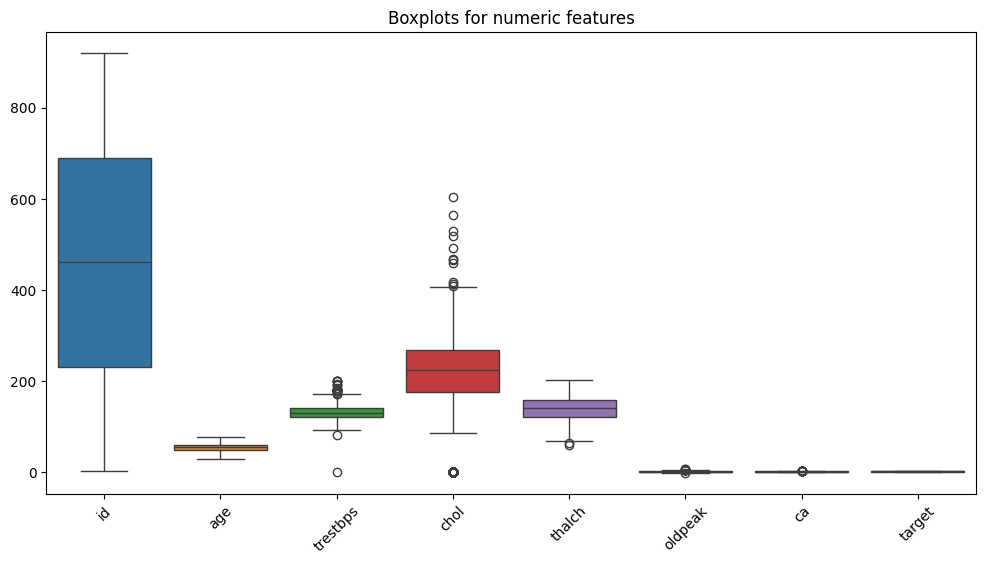

In [7]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=45)
plt.title("Boxplots for numeric features")
plt.show()

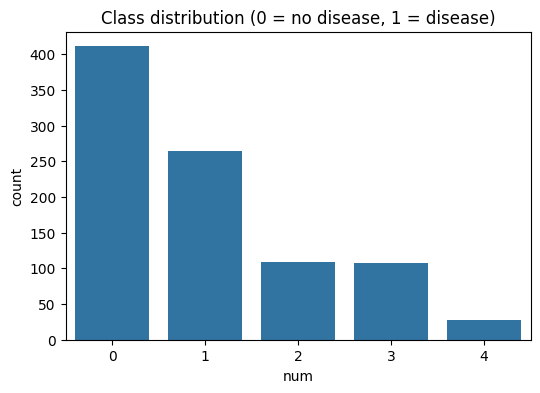

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title("Class distribution (0 = no disease, 1 = disease)")
plt.show()

#Data Cleanup

In [9]:
# Replace '?' with NaN and coerce certain columns to numeric
df = df.replace('?', np.nan)
df = df.replace(' ? ', np.nan)

# Columns that sometimes have non-numeric entries: ca, thal
for col in ['ca', 'thal']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Show missing counts again
print("Missing counts after coercion:")
display(df.isnull().sum())


Missing counts after coercion:


,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


#More Visual EDA

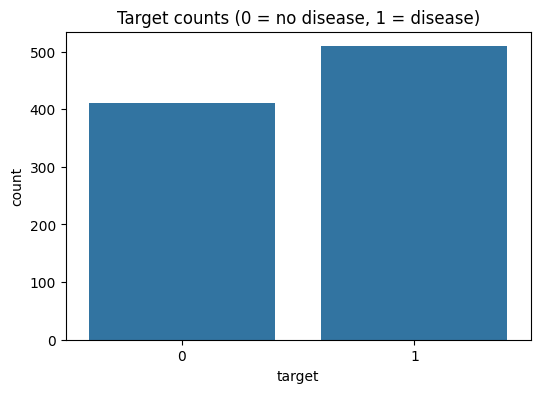

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df)
plt.title("Target counts (0 = no disease, 1 = disease)")
plt.show()

Age distribution

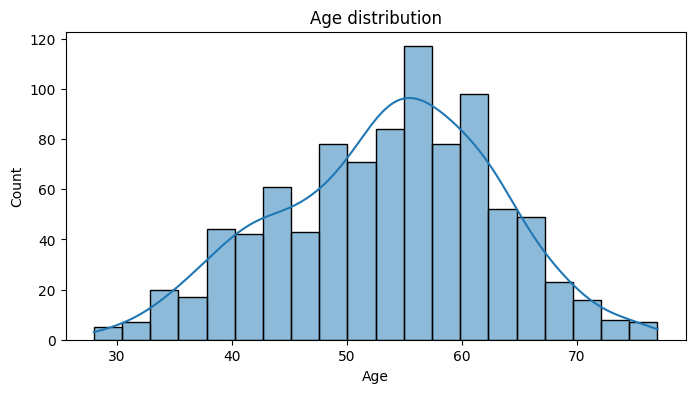

In [11]:
plt.figure(figsize=(8,4))
sns.histplot(df['age'].dropna(), bins=20, kde=True)
plt.title("Age distribution")
plt.xlabel("Age")
plt.show()


Chest pain types

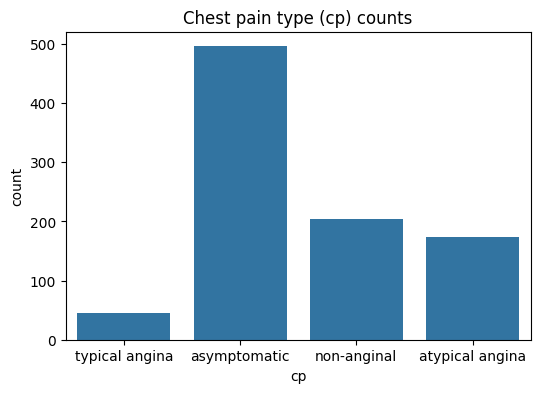

In [12]:
if 'cp' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='cp', data=df)
    plt.title("Chest pain type (cp) counts")
    plt.show()

Correlation heatmap for numeric features

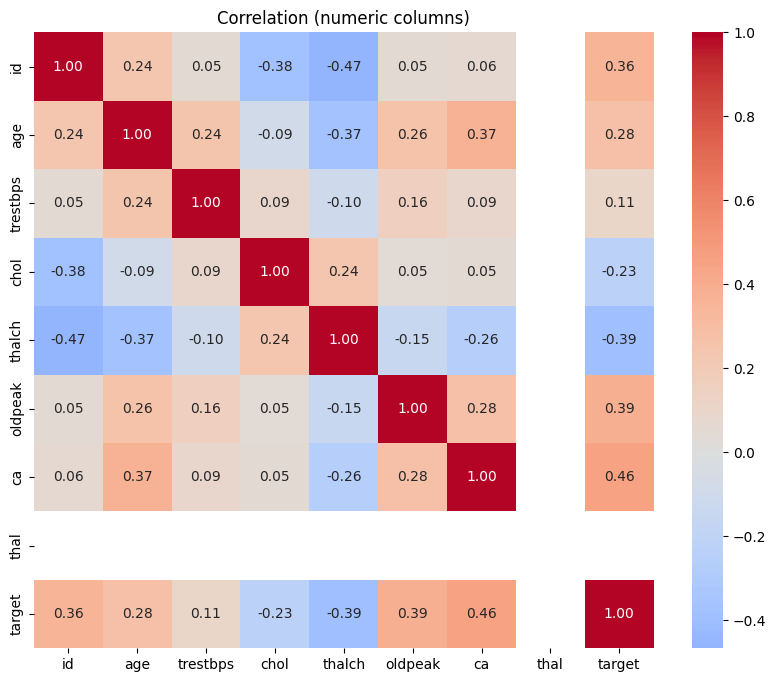

In [13]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# exclude the original 'num' if present and keep 'target'
if 'num' in numeric_cols:
    numeric_cols.remove('num')
if 'target' in numeric_cols and len(numeric_cols)>1:
    # keep target to show correlations with it
    pass

plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation (numeric columns)")
plt.show()

#Feature Grouping

In [14]:
all_cols = df.columns.tolist()
print("All columns:", all_cols)

# Typical numeric columns in this dataset
numeric_features = []
for c in ['age','trestbps','chol','thalach','oldpeak','ca']:
    if c in df.columns:
        numeric_features.append(c)

# Typical categorical (nominal/ordinal) columns
categorical_features = []
for c in ['sex','cp','fbs','restecg','exang','slope','thal','origin']:
    if c in df.columns:
        categorical_features.append(c)

# Remove target from feature lists if present
if 'target' in numeric_features: numeric_features.remove('target')
if 'target' in categorical_features: categorical_features.remove('target')

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


All columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'target']
Numeric features: ['age', 'trestbps', 'chol', 'oldpeak', 'ca']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


#Train/Test Split

In [15]:
X = df.drop(columns=[c for c in ['num', 'target'] if c in df.columns]).copy()
y = df['target'].copy()

# If there are extra index/id columns like 'id', drop them
if 'id' in X.columns:
    X = X.drop(columns=['id'])

# Keep consistent columns: remove any columns that are all null or constant
nunique = X.nunique(dropna=True)
to_drop = nunique[nunique <= 1].index.tolist()
if to_drop:
    print("Dropping constant or single-value cols:", to_drop)
    X = X.drop(columns=to_drop)

# Final feature lists update (in case previous lists included dropped columns)
numeric_features = [c for c in numeric_features if c in X.columns]
categorical_features = [c for c in categorical_features if c in X.columns]

print("Final numeric features:", numeric_features)
print("Final categorical features:", categorical_features)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train_raw.shape, "Test shape:", X_test_raw.shape)


Dropping constant or single-value cols: ['thal']
Final numeric features: ['age', 'trestbps', 'chol', 'oldpeak', 'ca']
Final categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']
Train shape: (736, 13) Test shape: (184, 13)


#Preprocessing

In [16]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # numeric median imputation
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')  # drop any other columns not specified

# Fit the preprocessor on training data and transform both train/test
preprocessor.fit(X_train_raw)

X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# get feature names for transformed data (sklearn >=1.0)
try:
    feature_names = preprocessor.get_feature_names_out()
    feature_names = [f.replace('num__', '').replace('cat__', '') for f in feature_names]
except Exception:
    # fallback: create generic names
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

print("Processed X_train shape:", X_train.shape)
print("Sample feature names (first 20):", feature_names[:20])

Processed X_train shape: (736, 21)
Sample feature names (first 20): ['age', 'trestbps', 'chol', 'oldpeak', 'ca', 'sex_Female', 'sex_Male', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_False', 'fbs_True', 'restecg_lv hypertrophy', 'restecg_normal', 'restecg_st-t abnormality', 'exang_False', 'exang_True', 'slope_downsloping', 'slope_flat']


converting transformed arrays back to dataframe (for easier inspection)

In [17]:
X_train_df = pd.DataFrame(X_train, columns=feature_names, index=X_train_raw.index)
X_test_df = pd.DataFrame(X_test, columns=feature_names, index=X_test_raw.index)

display(X_train_df.head())


,age,trestbps,chol,oldpeak,ca,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,...,fbs_False,fbs_True,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping
640,-0.063147,1.560270,-1.857816,-0.807883,-0.357920,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
743,2.180526,-0.116411,-1.857816,-0.335827,-0.357920,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
890,-0.063147,-0.451747,0.382627,1.080341,-0.357920,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
270,0.791586,0.442483,0.050710,0.985930,1.268187,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
654,0.257378,1.280823,-1.857816,-0.807883,-0.357920,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [18]:
joblib.dump(preprocessor, "preprocessor_heart_disease.joblib")
print("Saved preprocessor to preprocessor_heart_disease.joblib")

Saved preprocessor to preprocessor_heart_disease.joblib


In [19]:
# Evaluation helper function
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

def evaluate_classifier(model, X_test, y_test, display_plots=True):
    y_pred = model.predict(X_test)
    # some classifiers have predict_proba
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except Exception:
        # fallback to decision_function if available, else None
        try:
            y_proba = model.decision_function(X_test)
        except Exception:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    rocauc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print("Accuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1-score: {:.4f}".format(f1))
    if rocauc is not None:
        print("ROC AUC: {:.4f}".format(rocauc))
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    if display_plots:
        plt.figure(figsize=(5,4))
        ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues', values_format='d')
        plt.title("Confusion Matrix")
        plt.show()

        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}")
            plt.plot([0,1],[0,1],'--', linewidth=0.8)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.show()

Majority baseline evaluation:
Accuracy: 0.5543
Precision: 0.5543
Recall: 1.0000
F1-score: 0.7133
ROC AUC: 0.5000

Classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.55      1.00      0.71       102

    accuracy                           0.55       184
   macro avg       0.28      0.50      0.36       184
weighted avg       0.31      0.55      0.40       184



<Figure size 500x400 with 0 Axes>

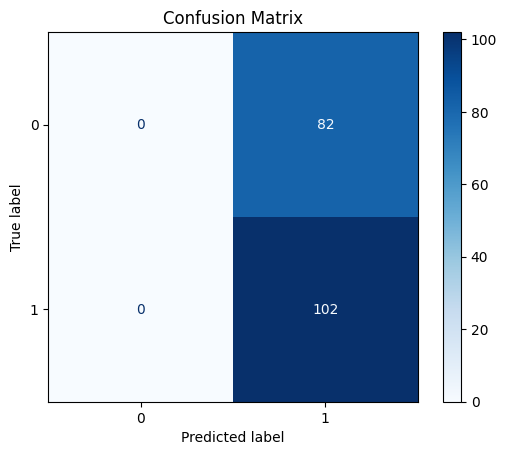

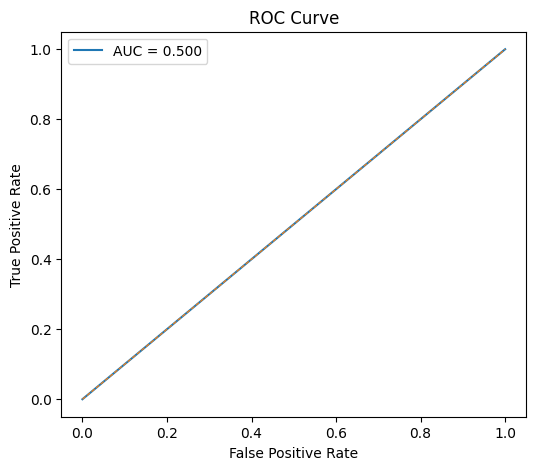

Logistic Regression baseline evaluation:
Accuracy: 0.8315
Precision: 0.8198
Recall: 0.8922
F1-score: 0.8545
ROC AUC: 0.8950

Classification report:

              precision    recall  f1-score   support

           0       0.85      0.76      0.80        82
           1       0.82      0.89      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



<Figure size 500x400 with 0 Axes>

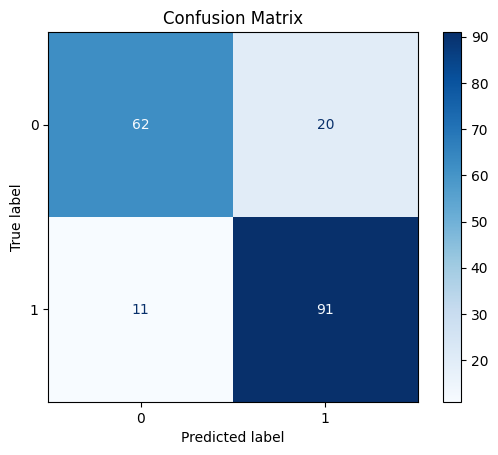

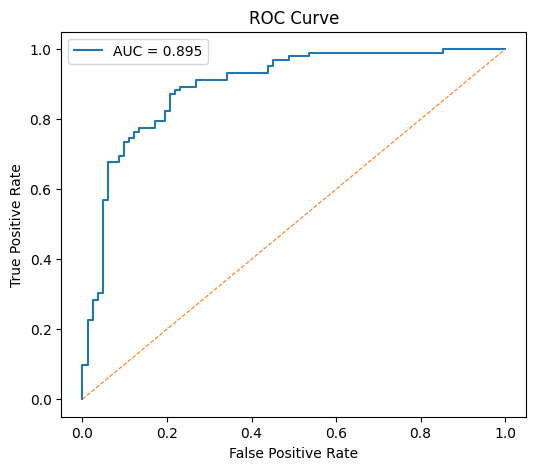

['logistic_baseline_heart.joblib']

In [20]:
# Baseline classifier: majority class and quick logistic regression baseline
from sklearn.dummy import DummyClassifier

# Majority baseline
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
print("Majority baseline evaluation:")
evaluate_classifier(dummy, X_test, y_test)

# Quick Logistic Regression baseline (small C, solver)
log_baseline = LogisticRegression(max_iter=1000, random_state=42)
log_baseline.fit(X_train, y_train)
print("Logistic Regression baseline evaluation:")
evaluate_classifier(log_baseline, X_test, y_test)

# Save baseline model(s) if desired
joblib.dump(log_baseline, "logistic_baseline_heart.joblib")


In [21]:
np.savez("processed_heart_data.npz", X_train=X_train, X_test=X_test, y_train=y_train.values, y_test=y_test.values)
print("Saved processed arrays to processed_heart_data.npz")

Saved processed arrays to processed_heart_data.npz


#KNN

In [22]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import time

Grid search for best KNN hyperparameters

In [23]:
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 13],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "chebyshev"]  # common choices
}

# Use stratified CV because this is a classification problem
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn = KNeighborsClassifier()

# We'll evaluate multiple metrics but refit according to F1 (harmonic mean of precision & recall).
scoring = ["accuracy", "f1", "roc_auc"]

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",             # final best_estimator_ is the one with best F1 on CV
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

start = time.time()
grid.fit(X_train, y_train)
end = time.time()
print(f"GridSearchCV finished in {(end-start):.1f} seconds")

print("Best params (by F1):", grid.best_params_)
print("Best CV F1 score:", grid.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
GridSearchCV finished in 10.3 seconds
Best params (by F1): {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Best CV F1 score: 0.8385666647799892


top CV results (KNN)

In [24]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
# keep relevant columns and sort
cols = [
    "rank_test_f1", "mean_test_f1", "std_test_f1",
    "mean_test_accuracy", "std_test_accuracy",
    "mean_test_roc_auc", "std_test_roc_auc",
    "params"
]
display(results[cols].sort_values("rank_test_f1").head(10))

,rank_test_f1,mean_test_f1,std_test_f1,mean_test_accuracy,std_test_accuracy,mean_test_roc_auc,std_test_roc_auc,params
6,1,0.838567,0.029205,0.813918,0.037779,0.881340,0.023073,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei..."
8,2,0.837822,0.017090,0.813900,0.023417,0.885459,0.019702,"{'metric': 'euclidean', 'n_neighbors': 11, 'we..."
4,3,0.836995,0.027597,0.812539,0.034598,0.876561,0.026850,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei..."
5,4,0.836381,0.020951,0.812530,0.026137,0.874955,0.023061,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei..."
7,5,0.836114,0.022257,0.812539,0.028431,0.878791,0.022505,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei..."
10,6,0.832397,0.020618,0.809809,0.026308,0.884833,0.020253,"{'metric': 'euclidean', 'n_neighbors': 13, 'we..."
3,7,0.832146,0.015834,0.807115,0.022902,0.866698,0.021548,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei..."
11,8,0.831435,0.017049,0.809809,0.021248,0.882486,0.019188,"{'metric': 'euclidean', 'n_neighbors': 13, 'we..."
9,9,0.831222,0.009512,0.808448,0.013490,0.882946,0.019630,"{'metric': 'euclidean', 'n_neighbors': 11, 'we..."
2,10,0.831160,0.025946,0.804403,0.033865,0.865788,0.023696,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei..."


evaluating the best estimator

Best KNN: KNeighborsClassifier(metric='euclidean', n_neighbors=9)
Accuracy: 0.8315
Precision: 0.8087
Recall: 0.9118
F1-score: 0.8571
ROC AUC: 0.8963

Classification report:

              precision    recall  f1-score   support

           0       0.87      0.73      0.79        82
           1       0.81      0.91      0.86       102

    accuracy                           0.83       184
   macro avg       0.84      0.82      0.83       184
weighted avg       0.84      0.83      0.83       184



<Figure size 500x400 with 0 Axes>

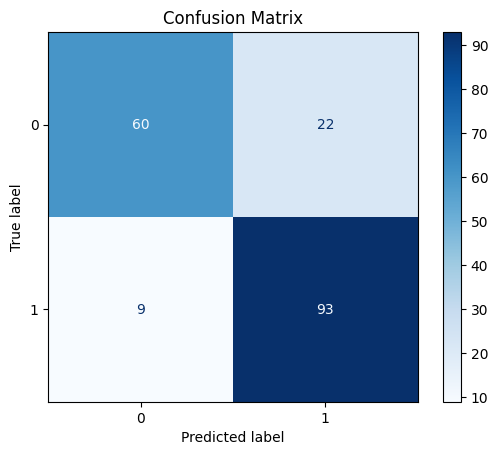

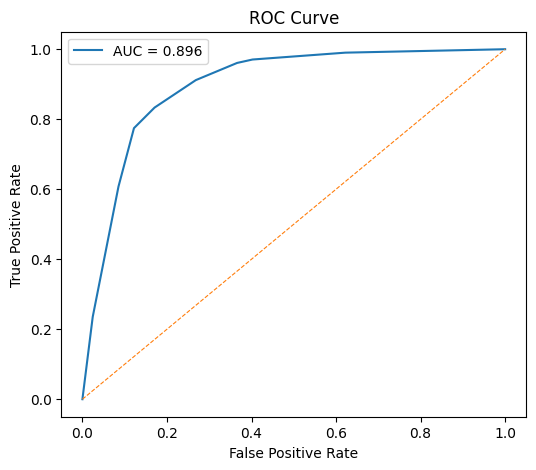

In [25]:
best_knn = grid.best_estimator_
print("Best KNN:", best_knn)

# Evaluate using the helper you already have (prints metrics + plots)
evaluate_classifier(best_knn, X_test, y_test, display_plots=True)


In [26]:
from sklearn.neighbors import NearestNeighbors

# pick some indices from X_test_df if you converted earlier, otherwise use raw arrays
sample_indices = [0, 1, 2]  # adjustable
# fit a NearestNeighbors on training data to inspect neighbors (using same metric as best_knn)
nn = NearestNeighbors(n_neighbors=5, metric=best_knn.metric)
nn.fit(X_train)

for idx in sample_indices:
    x = X_test[idx].reshape(1, -1)
    neigh_dists, neigh_idx = nn.kneighbors(x, return_distance=True)
    print(f"\nSample test index: {idx}, true label: {y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]}")
    print("Predicted by KNN:", best_knn.predict(x)[0])
    print("Neighbor train indices:", neigh_idx[0])
    print("Neighbor distances:", neigh_dists[0])


Sample test index: 0, true label: 1
Predicted by KNN: 0
Neighbor train indices: [237 311 247 478 635]
Neighbor distances: [0.32807117 0.35284259 0.48125462 0.49648066 0.58045604]

Sample test index: 1, true label: 1
Predicted by KNN: 1
Neighbor train indices: [ 91 435 509 118 392]
Neighbor distances: [1.64980345 1.92692411 2.05611286 2.06916763 2.1060173 ]

Sample test index: 2, true label: 1
Predicted by KNN: 1
Neighbor train indices: [576 346  59 307  48]
Neighbor distances: [1.56666597 1.72981067 1.78994289 1.89668506 1.90701291]


Saving best model

In [27]:
import joblib
joblib.dump(best_knn, "knn_best_heart_model.joblib")
print("Saved best KNN to knn_best_heart_model.joblib")

Saved best KNN to knn_best_heart_model.joblib


#Logistic Regression

In [28]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
import time

Grid search for best LR hyperparameters

In [29]:
param_grid_lr = {
    "penalty": ["l2", "l1"],          # l1 or l2 regularization
    "C": [0.01, 0.1, 1.0, 10.0, 100.0],  # inverse regularization strength
    "class_weight": [None, "balanced"],  # handle class imbalance
    # solver must be compatible with penalty: 'liblinear' supports l1 & l2; 'saga' supports both and is good for larger datasets
    "solver": ["liblinear", "saga"],
    # note: if using 'saga' with l1 and small data, random_state helps reproducibility
    "max_iter": [1000]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr = LogisticRegression(random_state=42)

grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring=['accuracy', 'f1', 'roc_auc'],
    refit='f1',   # choose final model by best CV F1
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

start = time.time()
grid_lr.fit(X_train, y_train)
end = time.time()
print(f"Grid search finished in {(end-start):.1f} seconds")
print("Best params (by F1):", grid_lr.best_params_)
print("Best CV F1 score:", grid_lr.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid search finished in 6.6 seconds
Best params (by F1): {'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best CV F1 score: 0.8333558539835699


top CV results (LR)

In [30]:
import pandas as pd
results_lr = pd.DataFrame(grid_lr.cv_results_)
cols = [
    "rank_test_f1", "mean_test_f1", "std_test_f1",
    "mean_test_accuracy", "std_test_accuracy",
    "mean_test_roc_auc", "std_test_roc_auc",
    "params"
]
display(results_lr[cols].sort_values("rank_test_f1").head(10))

,rank_test_f1,mean_test_f1,std_test_f1,mean_test_accuracy,std_test_accuracy,mean_test_roc_auc,std_test_roc_auc,params
9,1,0.833356,0.016062,0.811188,0.025908,0.884473,0.023691,"{'C': 0.1, 'class_weight': None, 'max_iter': 1..."
8,2,0.831393,0.016413,0.808467,0.026644,0.884435,0.023610,"{'C': 0.1, 'class_weight': None, 'max_iter': 1..."
26,3,0.828555,0.020260,0.805764,0.029842,0.882339,0.023714,"{'C': 10.0, 'class_weight': None, 'max_iter': ..."
27,3,0.828555,0.020260,0.805764,0.029842,0.882376,0.023609,"{'C': 10.0, 'class_weight': None, 'max_iter': ..."
24,3,0.828555,0.020260,0.805764,0.029842,0.882189,0.023816,"{'C': 10.0, 'class_weight': None, 'max_iter': ..."
25,3,0.828555,0.020260,0.805764,0.029842,0.882227,0.023872,"{'C': 10.0, 'class_weight': None, 'max_iter': ..."
17,3,0.828555,0.020260,0.805764,0.029842,0.883200,0.023996,"{'C': 1.0, 'class_weight': None, 'max_iter': 1..."
16,3,0.828555,0.020260,0.805764,0.029842,0.883238,0.024226,"{'C': 1.0, 'class_weight': None, 'max_iter': 1..."
35,9,0.827170,0.018918,0.804403,0.028847,0.882152,0.023923,"{'C': 100.0, 'class_weight': None, 'max_iter':..."
34,9,0.827170,0.018918,0.804403,0.028847,0.882152,0.023923,"{'C': 100.0, 'class_weight': None, 'max_iter':..."


evaluation and save best model

Best logistic regression estimator:
LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='saga')
Accuracy: 0.8370
Precision: 0.8333
Recall: 0.8824
F1-score: 0.8571
ROC AUC: 0.8953

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.78      0.81        82
           1       0.83      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



<Figure size 500x400 with 0 Axes>

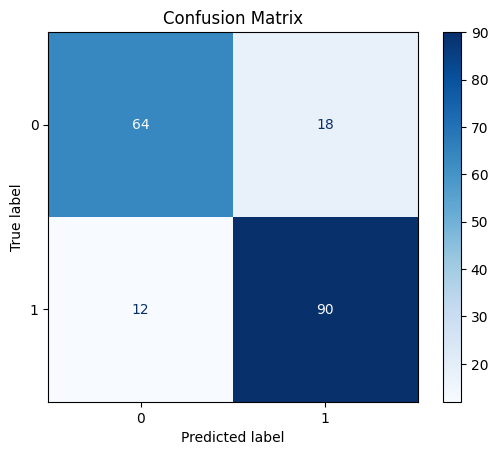

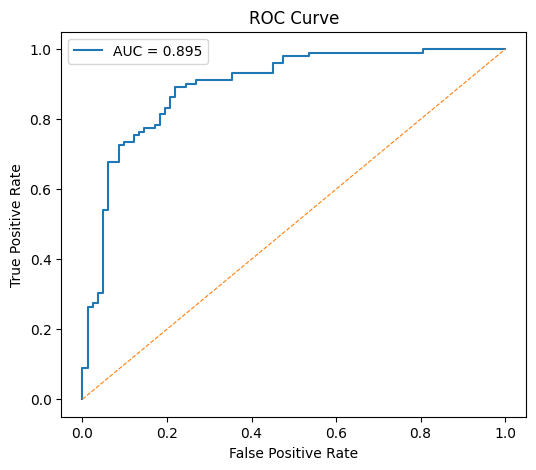

Saved best logistic model to logistic_best_heart_model.joblib


In [31]:
best_lr = grid_lr.best_estimator_
print("Best logistic regression estimator:")
print(best_lr)

evaluate_classifier(best_lr, X_test, y_test, display_plots=True)

import joblib
joblib.dump(best_lr, "logistic_best_heart_model.joblib")
print("Saved best logistic model to logistic_best_heart_model.joblib")


In [32]:
try:
    coefs = best_lr.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df['abs_coef'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False)
    display(coef_df.head(15))
except Exception as e:
    print("Could not show coefficients. Reason:", e)

,feature,coef,abs_coef
7,cp_asymptomatic,0.888905,0.888905
8,cp_atypical angina,-0.655655,0.655655
16,exang_False,-0.525230,0.525230
17,exang_True,0.522878,0.522878
5,sex_Female,-0.497293,0.497293
6,sex_Male,0.494941,0.494941
4,ca,0.451873,0.451873
3,oldpeak,0.451759,0.451759
2,chol,-0.451749,0.451749
19,slope_flat,0.410189,0.410189


#Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import time

Grid search for best NB hyperparameters

In [34]:
param_grid_nb = {
    "var_smoothing": np.logspace(-12, -6, 13)  # common range to try
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gnb = GaussianNB()

grid_nb = GridSearchCV(
    estimator=gnb,
    param_grid=param_grid_nb,
    scoring=["accuracy", "f1", "roc_auc"],
    refit="f1",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

start = time.time()
grid_nb.fit(X_train, y_train)
end = time.time()
print(f"GridSearchCV finished in {(end-start):.1f} seconds")
print("Best params (by F1):", grid_nb.best_params_)
print("Best CV F1 score:", grid_nb.best_score_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
GridSearchCV finished in 0.9 seconds
Best params (by F1): {'var_smoothing': np.float64(1e-12)}
Best CV F1 score: 0.8134975094914043


top CV results (NB)

In [35]:
import pandas as pd
results_nb = pd.DataFrame(grid_nb.cv_results_)
cols = [
    "rank_test_f1", "mean_test_f1", "std_test_f1",
    "mean_test_accuracy", "std_test_accuracy",
    "mean_test_roc_auc", "std_test_roc_auc",
    "params"
]
display(results_nb[cols].sort_values("rank_test_f1").head(10))

,rank_test_f1,mean_test_f1,std_test_f1,mean_test_accuracy,std_test_accuracy,mean_test_roc_auc,std_test_roc_auc,params
0,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 1e-12}
1,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 3.1622776601683794e-12}
2,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 1e-11}
3,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 3.1622776601683794e-11}
4,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 1e-10}
5,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 3.1622776601683795e-10}
6,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 1e-09}
7,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 3.1622776601683795e-09}
8,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 1e-08}
9,1,0.813498,0.007858,0.796222,0.014495,0.875364,0.0298,{'var_smoothing': 3.162277660168379e-08}


evaluate and save

Best GaussianNB: GaussianNB(var_smoothing=np.float64(1e-12))
Accuracy: 0.8098
Precision: 0.8252
Recall: 0.8333
F1-score: 0.8293
ROC AUC: 0.8874

Classification report:

              precision    recall  f1-score   support

           0       0.79      0.78      0.79        82
           1       0.83      0.83      0.83       102

    accuracy                           0.81       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.81      0.81      0.81       184



<Figure size 500x400 with 0 Axes>

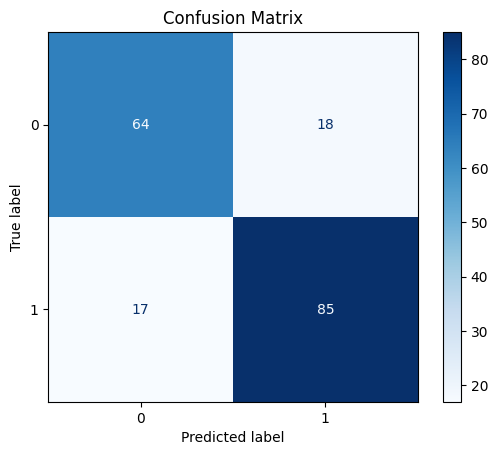

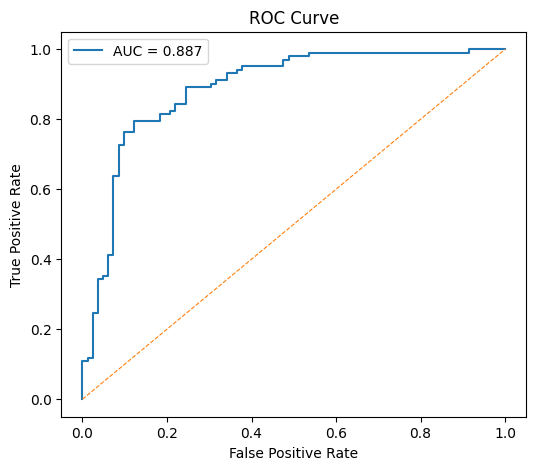

Saved best GaussianNB to gaussiannb_best_heart_model.joblib


In [36]:
best_nb = grid_nb.best_estimator_
print("Best GaussianNB:", best_nb)

evaluate_classifier(best_nb, X_test, y_test, display_plots=True)

import joblib
joblib.dump(best_nb, "gaussiannb_best_heart_model.joblib")
print("Saved best GaussianNB to gaussiannb_best_heart_model.joblib")

#Support Vector Machine

In [37]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

Grid search for best SVM hyperparameters

In [38]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_svc = [
    # linear kernel
    {"kernel": ["linear"], "C": [0.01, 0.1, 1, 10, 100]},
    # RBF kernel
    {"kernel": ["rbf"], "C": [0.1, 1, 10, 100], "gamma": ["scale", "auto", 0.01, 0.001, 0.0001]},
    # polynomial kernel
    {"kernel": ["poly"], "C": [0.1, 1, 10], "degree": [2,3], "gamma": ["scale", "auto"]}
]

svc = SVC(probability=True, random_state=42)

grid_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    scoring=["accuracy", "f1", "roc_auc"],
    refit="f1",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

start = time.time()
grid_svc.fit(X_train, y_train)
end = time.time()
print(f"SVC GridSearchCV finished in {(end-start):.1f} seconds")
print("Best params (by F1):", grid_svc.best_params_)
print("Best CV F1 score:", grid_svc.best_score_)

Fitting 5 folds for each of 37 candidates, totalling 185 fits
SVC GridSearchCV finished in 29.1 seconds
Best params (by F1): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV F1 score: 0.842120151745321


top CV results (SVM)

In [39]:
import pandas as pd
results_svc = pd.DataFrame(grid_svc.cv_results_)
cols = [
    "rank_test_f1", "mean_test_f1", "std_test_f1",
    "mean_test_accuracy", "std_test_accuracy",
    "mean_test_roc_auc", "std_test_roc_auc",
    "params"
]
display(results_svc[cols].sort_values("rank_test_f1").head(10))

,rank_test_f1,mean_test_f1,std_test_f1,mean_test_accuracy,std_test_accuracy,mean_test_roc_auc,std_test_roc_auc,params
10,1,0.842120,0.030465,0.816602,0.039994,0.886385,0.019676,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}"
29,2,0.840130,0.024724,0.816621,0.033586,0.880191,0.014544,"{'C': 1, 'degree': 2, 'gamma': 'scale', 'kerne..."
5,3,0.836618,0.025498,0.805736,0.037479,0.887359,0.018035,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}"
17,4,0.835142,0.019648,0.813918,0.026905,0.887699,0.018341,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
22,5,0.834767,0.025747,0.809800,0.034583,0.879393,0.016878,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"
11,6,0.832410,0.022838,0.807097,0.032721,0.889828,0.019719,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}"
12,7,0.830951,0.020313,0.808485,0.029750,0.885331,0.021197,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"
27,8,0.830806,0.014520,0.811188,0.018385,0.887868,0.019253,"{'C': 0.1, 'degree': 3, 'gamma': 'scale', 'ker..."
32,8,0.830806,0.014520,0.811188,0.018385,0.887867,0.019662,"{'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel..."
6,10,0.830698,0.021393,0.804376,0.030339,0.887478,0.020860,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}"


evaluate and save

Best SVM estimator:
SVC(C=1, probability=True, random_state=42)
Accuracy: 0.8315
Precision: 0.8087
Recall: 0.9118
F1-score: 0.8571
ROC AUC: 0.9119

Classification report:

              precision    recall  f1-score   support

           0       0.87      0.73      0.79        82
           1       0.81      0.91      0.86       102

    accuracy                           0.83       184
   macro avg       0.84      0.82      0.83       184
weighted avg       0.84      0.83      0.83       184



<Figure size 500x400 with 0 Axes>

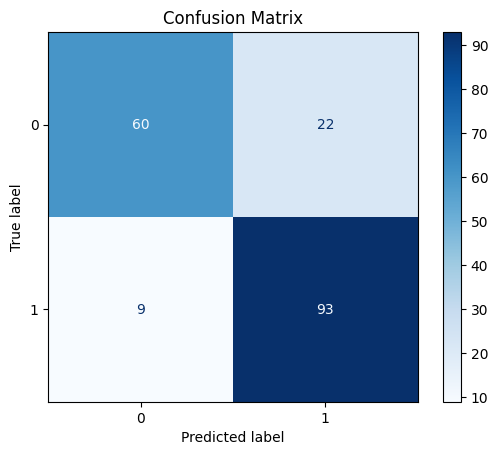

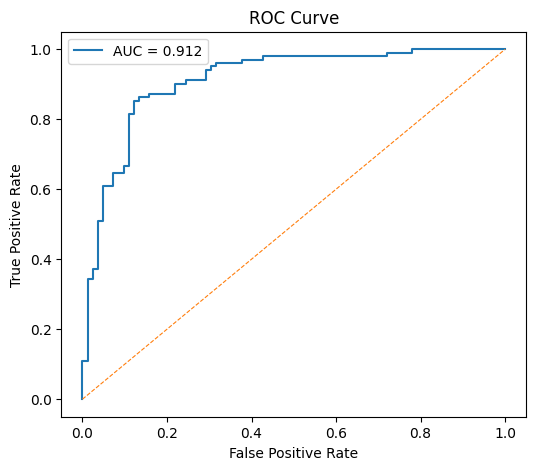

Saved best SVM to svm_best_heart_model.joblib


In [40]:
best_svm = grid_svc.best_estimator_
print("Best SVM estimator:")
print(best_svm)

# Use the evaluation helper already in the notebook
evaluate_classifier(best_svm, X_test, y_test, display_plots=True)

# Save model
import joblib
joblib.dump(best_svm, "svm_best_heart_model.joblib")
print("Saved best SVM to svm_best_heart_model.joblib")

#Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import scipy.stats as stats
import time
import joblib

randomized search

In [42]:
param_dist = {
    "n_estimators": [100, 200, 400, 800],
    "max_depth": [None, 6, 8, 12, 20],
    "min_samples_split": [2, 4, 8, 12],
    "min_samples_leaf": [1, 2, 4, 6],
    "max_features": ['sqrt', 'log2', 0.6, 0.8],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,               # number of random combinations to try (tweak to taste)
    scoring=['accuracy','f1','roc_auc'],
    refit='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

start = time.time()
rs.fit(X_train, y_train)
end = time.time()
print(f"RandomizedSearchCV done in {(end-start):.1f}s")
print("Best params (by F1):", rs.best_params_)
print("Best CV F1:", rs.best_score_)
best_rf = rs.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV done in 298.4s
Best params (by F1): {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 12, 'class_weight': None, 'bootstrap': False}
Best CV F1: 0.8275583572151868


evaluate and save

Accuracy: 0.8424
Precision: 0.8349
Recall: 0.8922
F1-score: 0.8626
ROC AUC: 0.9229

Classification report:

              precision    recall  f1-score   support

           0       0.85      0.78      0.82        82
           1       0.83      0.89      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



<Figure size 500x400 with 0 Axes>

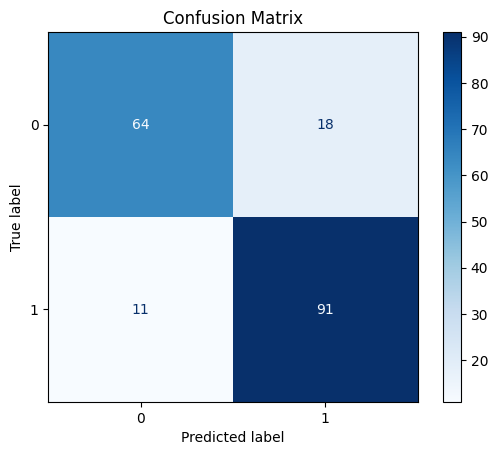

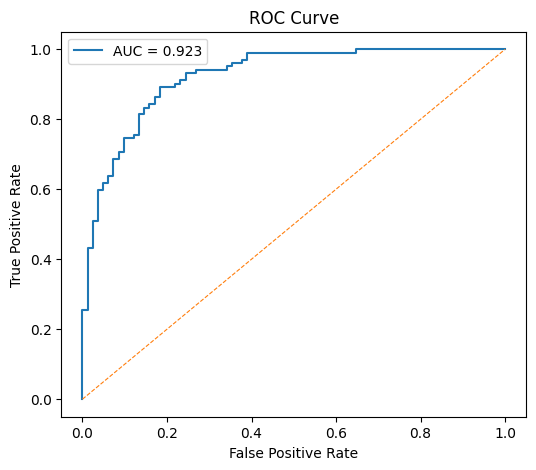

Saved best RF to randomforest_best_heart_model.joblib


In [43]:
evaluate_classifier(best_rf, X_test, y_test, display_plots=True)
joblib.dump(best_rf, "randomforest_best_heart_model.joblib")
print("Saved best RF to randomforest_best_heart_model.joblib")

permutation perf

In [47]:
# RF4 - feature importances & permutation importance (permutation is more reliable)
# Make sure `feature_names` exists (from preprocessing step)
import pandas as pd
from sklearn.inspection import permutation_importance

try:
    fi = best_rf.feature_importances_
    fi_df = pd.DataFrame({"feature": feature_names, "importance": fi}).sort_values("importance", ascending=False)
    display(fi_df.head(20))
except Exception as e:
    print("Could not show built-in feature_importances_:", e)

# Permutation importance (slower but unbiased)
print("Running permutation importance (this may take some time)...")
perm = permutation_importance(best_rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({"feature": feature_names, "importance_mean": perm.importances_mean, "importance_std": perm.importances_std})
perm_df = perm_df.sort_values("importance_mean", ascending=False)
display(perm_df.head(20))
perm_df.to_csv("rf_permutation_importance.csv")
print("Saved permutation importances to rf_permutation_importance.csv")


,feature,importance
7,cp_asymptomatic,0.188661
2,chol,0.128667
3,oldpeak,0.100550
17,exang_True,0.099240
0,age,0.098319
16,exang_False,0.088019
8,cp_atypical angina,0.067066
5,sex_Female,0.042360
6,sex_Male,0.038453
1,trestbps,0.034506


Running permutation importance (this may take some time)...


,feature,importance_mean,importance_std
2,chol,0.038043,0.016839
7,cp_asymptomatic,0.018841,0.014899
8,cp_atypical angina,0.018116,0.007201
3,oldpeak,0.016304,0.010779
4,ca,0.012319,0.005423
1,trestbps,0.004348,0.008582
6,sex_Male,0.003623,0.008222
15,restecg_st-t abnormality,0.003442,0.005340
5,sex_Female,0.002174,0.007372
12,fbs_True,0.000543,0.002927


Saved permutation importances to rf_permutation_importance.csv


finalizing

              Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
                SVM  0.831522   0.808696 0.911765  0.857143 0.911884
Logistic Regression  0.836957   0.833333 0.882353  0.857143 0.895265
      Random Forest  0.842391   0.834862 0.892157  0.862559 0.922884
        Naive Bayes  0.809783   0.825243 0.833333  0.829268 0.887374
                KNN  0.831522   0.808696 0.911765  0.857143 0.896282

Best model: Random Forest  |  F1=0.862559  ROC_AUC=0.922884  Accuracy=0.842391


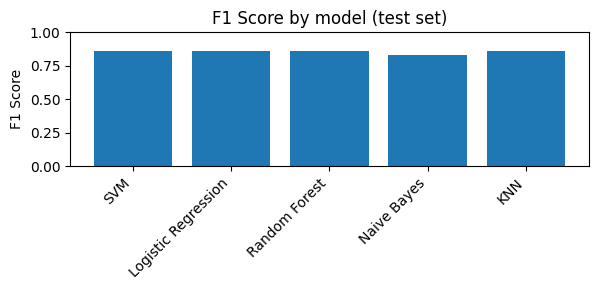

In [44]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

models = {
    "SVM": globals().get("best_svm"),
    "Logistic Regression": globals().get("best_lr"),
    "Random Forest": globals().get("best_rf"),
    "Naive Bayes": globals().get("best_nb"),
    "KNN": globals().get("best_knn")
}

# Require X_test and y_test (preprocessed arrays)
if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("X_test or y_test not found. Run preprocessing & models first.")

rows = []
for name, model in models.items():
    if model is None:
        continue
    try:
        y_pred = model.predict(X_test)
    except Exception as e:
        print(f"Skipping {name} (predict failed): {e}")
        continue

    # try get scores for ROC AUC, else NaN
    y_score = None
    try:
        y_score = model.predict_proba(X_test)[:,1]
    except Exception:
        try:
            y_score = model.decision_function(X_test)
        except Exception:
            y_score = None

    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    })

df = pd.DataFrame(rows)[["Model","Accuracy","Precision","Recall","F1 Score","ROC AUC"]]
df[["Accuracy","Precision","Recall","F1 Score","ROC AUC"]] = df[["Accuracy","Precision","Recall","F1 Score","ROC AUC"]].astype(float).round(6)

print(df.to_string(index=False))

# print best model (tie-breaker: F1 -> ROC AUC -> Accuracy)
if not df.empty:
    df_sorted = df.sort_values(by=["F1 Score","ROC AUC","Accuracy"], ascending=[False, False, False])
    best = df_sorted.iloc[0]
    print(f"\nBest model: {best['Model']}  |  F1={best['F1 Score']:.6f}  ROC_AUC={best['ROC AUC']:.6f}  Accuracy={best['Accuracy']:.6f}")

# small visual: F1 bar chart (minimal)
try:
    plt.figure(figsize=(6,3))
    plt.bar(df['Model'], df['F1 Score'])
    plt.ylim(0,1)
    plt.ylabel('F1 Score')
    plt.title('F1 Score by model (test set)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plot skipped:", e)


#Cross validating ML models

In [45]:
import numpy as np, pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

models = {
    "SVM": globals().get("best_svm"),
    "Logistic Regression": globals().get("best_lr"),
    "Random Forest": globals().get("best_rf"),
    "Naive Bayes": globals().get("best_nb"),
    "KNN": globals().get("best_knn")
}

# Prefer raw X,y (so preprocessor can be included); fallback to concatenating train/test raw if available
if 'X' in globals() and 'y' in globals():
    X_for_cv, y_for_cv = globals()['X'], globals()['y']
elif 'X_train_raw' in globals() and 'X_test_raw' in globals() and 'y_train' in globals() and 'y_test' in globals():
    X_for_cv = pd.concat([X_train_raw, X_test_raw], axis=0)
    y_for_cv = pd.concat([y_train, y_test], axis=0)
else:
    raise RuntimeError("Raw X and y not found for cross-validation. Make sure 'X' and 'y' (raw) exist.")

use_preproc = 'preprocessor' in globals() and globals()['preprocessor'] is not None
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'f1_macro'

cv_summary = []
for name, model in models.items():
    if model is None:
        continue
    try:
        if use_preproc:
            pipe = Pipeline([('preprocessor', preprocessor), ('clf', model)])
            scores = cross_val_score(pipe, X_for_cv, y_for_cv, cv=cv, scoring=scoring, n_jobs=-1)
        else:
            scores = cross_val_score(model, X_for_cv, y_for_cv, cv=cv, scoring=scoring, n_jobs=-1)
        print(f"{name} - Mean F1_macro: {scores.mean():.4f} ± {scores.std():.4f}")
        cv_summary.append({"Model": name, "Mean_F1_macro": scores.mean(), "Std_F1_macro": scores.std()})
    except Exception as e:
        print(f"CV failed for {name}: {e}")

df_cv = pd.DataFrame(cv_summary)[["Model","Mean_F1_macro","Std_F1_macro"]]
df_cv.to_csv("models_cv_f1_macro_simple.csv", index=False)
print("\nSaved -> models_cv_f1_macro_simple.csv")

SVM - Mean F1_macro: 0.8197 ± 0.0188
Logistic Regression - Mean F1_macro: 0.8112 ± 0.0330
Random Forest - Mean F1_macro: 0.8159 ± 0.0179
Naive Bayes - Mean F1_macro: 0.8024 ± 0.0252
KNN - Mean F1_macro: 0.8190 ± 0.0289

Saved -> models_cv_f1_macro_simple.csv


Final Verdict

              Model    Accuracy   Precision      Recall    F1 Score
      Random Forest 0.842391000 0.834862000 0.892157000 0.862559000
                SVM 0.831522000 0.808696000 0.911765000 0.857143000
                KNN 0.831522000 0.808696000 0.911765000 0.857143000
Logistic Regression 0.836957000 0.833333000 0.882353000 0.857143000
        Naive Bayes 0.809783000 0.825243000 0.833333000 0.829268000

Best model: Random Forest  |  F1=0.862559  ROC_AUC=0.922884  Accuracy=0.842391


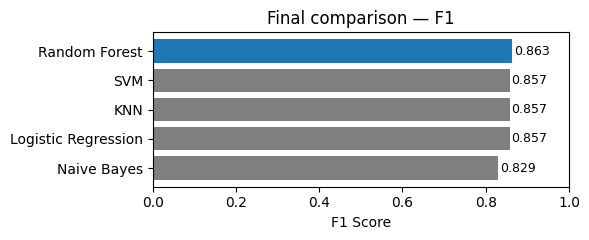

In [67]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "SVM": globals().get("best_svm"),
    "Logistic Regression": globals().get("best_lr"),
    "Random Forest": globals().get("best_rf"),
    "Naive Bayes": globals().get("best_nb"),
    "KNN": globals().get("best_knn")
}

if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("X_test or y_test not found — run preprocessing and model training first.")

rows = []
for name, model in models.items():
    if model is None:
        continue
    try:
        y_pred = model.predict(X_test)
    except Exception as e:
        print(f"Skipping {name} (predict failed): {e}")
        continue

    y_score = None
    try:
        y_score = model.predict_proba(X_test)[:,1]
    except Exception:
        try:
            y_score = model.decision_function(X_test)
        except Exception:
            y_score = None

    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    })

df = pd.DataFrame(rows)[["Model","Accuracy","Precision","Recall","F1 Score","ROC AUC"]]
df[["Accuracy","Precision","Recall","F1 Score","ROC AUC"]] = df[["Accuracy","Precision","Recall","F1 Score","ROC AUC"]].astype(float).round(6)

# pick best: F1 primary, ROC AUC secondary, Accuracy tertiary
if not df.empty:
    df_sorted = df.sort_values(by=["F1 Score","ROC AUC","Accuracy"], ascending=[False, False, False]).reset_index(drop=True)
    best_name = df_sorted.loc[0, "Model"]
    df_sorted["Best"] = ["<< BEST" if m==best_name else "" for m in df_sorted["Model"]]
else:
    df_sorted = df.copy()
    best_name = None

print(df_sorted[["Model","Accuracy","Precision","Recall","F1 Score"]].to_string(index=False))

if best_name:
    best_row = df_sorted.loc[0]
    print(f"\nBest model: {best_name}  |  F1={best_row['F1 Score']:.6f}  ROC_AUC={best_row['ROC AUC']:.6f}  Accuracy={best_row['Accuracy']:.6f}")

if not df_sorted.empty:
    plt.figure(figsize=(6, max(2, 0.5*len(df_sorted))))
    y = df_sorted["Model"]
    x = df_sorted["F1 Score"]
    colors = ['tab:gray' if m != best_name else 'tab:blue' for m in df_sorted["Model"]]
    plt.barh(y, x, color=colors)
    for xi, yi in zip(x, y):
        plt.text(xi + 0.005, yi, f"{xi:.3f}", va='center', fontsize=9)
    plt.xlim(0,1)
    plt.xlabel("F1 Score")
    plt.title("Final comparison — F1")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()